### Тест CNN модели для cifar10 на pytorch

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn 
import torch.nn.functional as F
from torch import optim
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# Базовые настройки

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

n_epochs = 50
train_batch_size = 128
test_batch_size = 10

train_path = './cifar10/train/'
test_path  = './cifar10/test/'
model_path = './cifar10/model.pth'

In [4]:
"""
Загрузка и предобработка датасета через torch DataLoader 
(конвертация в torch тензоры и стандартизация)

# Стандартизация неплохо работает в CNN 
и помогает лучше справляться с проблемой затухающих градиентов
Приводим mean и std для каждого канала изображения к диапазону [-1,1] 
"""
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root=train_path,
                                             train=True,  
                                             transform=transform, 
                                             download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=train_batch_size, 
                                           shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root=test_path,
                                            train=False,
                                            download=True,
                                            transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=test_batch_size,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def convert_to_imshow_format(image):
    """
    Конвертация изображений для визуализации
    - возврат диапазона (0, 1)
    - преобразование порядка размерностей CHW -> HWC (3x32x32 -> 32x32x3)
    """
    image = image / 2 + 0.5
    image = image.numpy()
    return image.transpose(1,2,0)

def show_images(n_show: int,
                loader: object,
                classes: dict = classes,
                estimator: callable = None
               ):
    """
    Визуализация изображений из torch DataLoader
    
    Parameters
    ----------
    
    n_show: int
        Количество выводимых изображений. (Работает с > 5)
        
    loader: torch.utils.data.dataloader.DataLoader
        Датасет из torch DataLoader
        
    classes: dict
        Список наименований меток классов
    estimator: callable
        CNN Модель. Если передан, то выводит предсказанный класс
    """
    dataiter = iter(loader)
    images, labels = dataiter.next()
    images, labels = images[:n_show], labels[:n_show]
    n_rows = n_show//5 + int((n_show%5 > 0))
    fig, axes = plt.subplots(n_rows, 5, figsize=(14, n_rows*2.5))
    if estimator:
        outputs = estimator(images)
        probs, index = torch.max(outputs, dim=1)
        _, pred = torch.max(outputs, 1)
        
    for idx, image in enumerate(images):
        axes[idx//5, idx%5].imshow(convert_to_imshow_format(image))
        if estimator:
            axes[idx//5, idx%5].set_title(f'truth {classes[labels[idx]]}, pred: {classes[pred[idx]]}')
        else: 
            axes[idx//5, idx%5].set_title(f'truth {classes[labels[idx]]}')
        axes[idx//5, idx%5].set_xticks([])
        axes[idx//5, idx%5].set_yticks([])

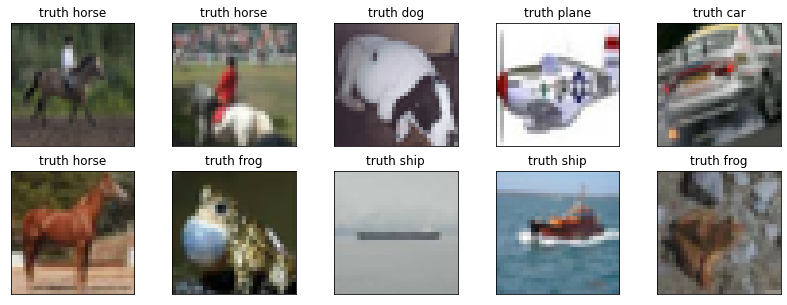

In [6]:
show_images(n_show=10, loader=train_loader)

In [8]:
class Cifar10Net(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=6,
                               kernel_size=5,
                               padding=0)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5,
                               padding=0)
        
        
#         self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        # x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.dropout(x, 0.2)
        # x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Cifar10Net().to(device)

In [12]:
net

Cifar10Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [14]:
for epoch in range(n_epochs):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 300 == 0:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training is finished!')

[1,     1] loss: 0.001
[1,   301] loss: 0.280
[2,     1] loss: 0.001
[2,   301] loss: 0.236
[3,     1] loss: 0.001
[3,   301] loss: 0.222
[4,     1] loss: 0.001
[4,   301] loss: 0.211
[5,     1] loss: 0.001
[5,   301] loss: 0.203
[6,     1] loss: 0.001
[6,   301] loss: 0.196
[7,     1] loss: 0.001
[7,   301] loss: 0.189
[8,     1] loss: 0.001
[8,   301] loss: 0.184
[9,     1] loss: 0.001
[9,   301] loss: 0.180
[10,     1] loss: 0.001
[10,   301] loss: 0.177
[11,     1] loss: 0.001
[11,   301] loss: 0.173
[12,     1] loss: 0.000
[12,   301] loss: 0.169
[13,     1] loss: 0.001
[13,   301] loss: 0.166
[14,     1] loss: 0.000
[14,   301] loss: 0.163
[15,     1] loss: 0.001
[15,   301] loss: 0.161
[16,     1] loss: 0.001
[16,   301] loss: 0.158
[17,     1] loss: 0.000
[17,   301] loss: 0.154
[18,     1] loss: 0.001
[18,   301] loss: 0.153
[19,     1] loss: 0.001
[19,   301] loss: 0.151
[20,     1] loss: 0.001
[20,   301] loss: 0.147
[21,     1] loss: 0.001
[21,   301] loss: 0.146
[22,     1

In [10]:
# сохранение весов модели
torch.save(net.state_dict(), model_path)

### Inference mode

In [11]:
# инициализация модели, загрузка весов
net = Cifar10Net()
net.load_state_dict(torch.load(model_path)) 

<All keys matched successfully>

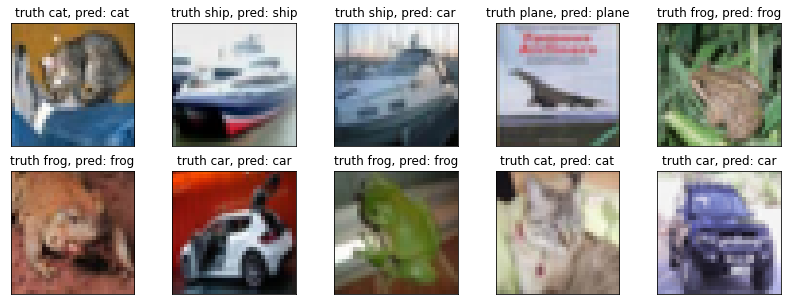

In [12]:
# Результат работы модели: 9/10
show_images(n_show=10, loader=test_loader, estimator=net)

### Соотнесение CNN функционала tensorflow с pytorch 

```{python}
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_catecorical_crossentropy',
              ...
...
...
```

In [13]:
class AsTfNet(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten(1, -1)
        self.linear1 = nn.Linear(28*28, 128)
        self.linear2 = nn.Linear(128, 10)
        

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = F.dropout(x, 0.2)
        x = self.linear2(x)
        x = F.softmax(x)
        return x